In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import cv2
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch import optim
import mlflow
from mlflow.tracking import MlflowClient
import json
import hydra
from omegaconf import DictConfig, OmegaConf
import albumentations as A
import time
import datetime
import sklearn.metrics

from utils import *
from implementations import *

import japanize_matplotlib
# pip install japanize-matplotlib

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Yu Mincho', 'Times New Roman']

In [4]:
def exname2model(experiment_name):
    ex_name = experiment_name.split("_")[0]
    if ex_name == "UNet":
        model_name = "UNet"
    elif ex_name == "BUNet":
        model_name = "BayesianUNet"
    elif ex_name == "AUNet":
        model_name = "AttentionUNet"
    elif ex_name == "BAUNet":
        model_name = "BayesianAttentionUNet"
    else:
        raise ValueError("未実装")
    
    model = Model[model_name](3, 1)
    return model

def img_mask2tensor(img, mask):
    transformed = A.Resize(256, 256)(image=img, mask=mask)
    X_data = transformed["image"]
    Y_data = transformed["mask"]
    X_data = transforms.ToTensor()(X_data)
    Y_data = mytransforms.TargetToTensor()(Y_data)
    return X_data, Y_data

def pred2output(X_data_orig, Y_pred, mode="RGB"):
    if mode == "RGB":
        Y_mask = np.where(Y_pred >= 0.5, 1, 0)
        Y_mask_color = np.array([Y_mask * c for c in COLOR]).transpose(1, 2, 0)
        output = X_data_orig.copy()
        output = np.where(Y_mask[..., np.newaxis] == 1, p_color*Y_mask_color+(1-p_color)*X_data_orig, X_data_orig).astype(np.uint8)
    elif mode == "HSV":
        Y_mask_pred = HSV_CENTER + (Y_pred - 0.5) * (2 * HSV_WIDTH)
        Y_mask_color = np.zeros((H_IMG_SIZE, W_IMG_SIZE, 3), dtype=np.uint8)
        Y_mask_color[:, :, 0] = 255
        Y_mask_hsv = cv2.cvtColor(Y_mask_color, cv2.COLOR_RGB2HSV_FULL)
        Y_mask_hsv[..., 0] = Y_mask_pred
        Y_mask = cv2.cvtColor(Y_mask_hsv, cv2.COLOR_HSV2RGB_FULL)
        output = p_color * Y_mask + (1-p_color) * X_data_orig
        output = output.astype(np.uint8)
    return output

def mclass2mname(model_class):
    return model_class.split("'")[1].split(".")[-1]

def model_prediction(model, img_path, mask_path):
    model.eval()
    if N_INFERENCE > 1:
        if str(model.__class__) == "<class 'torch.nn.parallel.data_parallel.DataParallel'>":
            model.module.enable_dropout()
        else:
            model.enable_dropout()
    
    if str(model.__class__) == "<class 'torch.nn.parallel.data_parallel.DataParallel'>":
        model_class_name = str(model.module.__class__)
    else:
        model_class_name = str(model.__class__)

    with torch.no_grad():
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)[..., 0]
        mask = np.where(mask == ORGAN_PIXEL, 1, 0)

        X_data, Y_data = img_mask2tensor(img, mask)
        X_data, Y_data = X_data.unsqueeze(0), Y_data.unsqueeze(0)

        if mclass2mname(model_class_name) in ["BayesianUNet", "BayesianAttentionUNet"]:
            X_data = X_data.to(cfg.device)
            Y_data = Y_data.to(cfg.device)
            tmp_Y_preds = []
            for j in range(N_INFERENCE):
                Y_pred = model(X_data)
                tmp_Y_preds.append(Y_pred)
            Y_pred = torch.stack(tmp_Y_preds).mean(axis=0).sigmoid().squeeze().cpu().numpy()
            Y_uncertainty = Y_preds2entropy(tmp_Y_preds, cfg.device).squeeze().cpu().numpy()
            Y_uncertainty_max = Y_preds2entropymax(tmp_Y_preds, cfg.device).squeeze().cpu().numpy()
        else:
            X_data = X_data.to(cfg.device)
            Y_data = Y_data.to(cfg.device)
            Y_pred = model(X_data).sigmoid().squeeze().cpu().numpy()
            Y_uncertainty = None
            Y_uncertainty_max = None
            
    dice_score = f_pytorch_with_sigmoid_each_data(Y_pred, Y_data).item()
    
    return Y_data, Y_pred, Y_uncertainty_max 

def model_prediction_using_dataloader(model, dataloader):
    s = time.time()
    model.eval()
    if N_INFERENCE > 1:
        if str(model.__class__) == "<class 'torch.nn.parallel.data_parallel.DataParallel'>":
            model.module.enable_dropout()
        else:
            model.enable_dropout()
            
    if str(model.__class__) == "<class 'torch.nn.parallel.data_parallel.DataParallel'>":
        model_class_name = str(model.module.__class__)
    else:
        model_class_name = str(model.__class__)
        

    with torch.no_grad():
        Y_preds = []
        Y_datas = []
        if mclass2mname(model_class_name) in ["BayesianUNet", "BayesianAttentionUNet"]:
            for X_data, Y_data in dataloader:
                X_data = X_data.to(cfg.device)
                Y_data = Y_data.to(cfg.device)
                tmp_Y_preds = []
                for j in range(N_INFERENCE):
                    Y_pred = model(X_data)
                    tmp_Y_preds.append(Y_pred)
                Y_pred = torch.stack(tmp_Y_preds).mean(axis=0)
                Y_preds.append(Y_pred)
                Y_datas.append(Y_data)
        else:
            for X_data, Y_data in dataloader:
                X_data = X_data.to(cfg.device)
                Y_data = Y_data.to(cfg.device)
                Y_pred = model(X_data)
                Y_preds.append(Y_pred)
                Y_datas.append(Y_data)

    Y_preds = torch.cat(Y_preds)
    Y_datas = torch.cat(Y_datas)
    e = time.time()
    print("{:.1f} (s)".format(e - s))
    
    print(np.mean(f_pytorch_with_sigmoid_each_data(Y_preds, Y_datas)))
    print(f_pytorch_with_sigmoid(Y_preds, Y_datas))
    
    return Y_preds, Y_datas

In [5]:
def f_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    pred_sum = Y_pred.sum((1, 2))
    target_sum = Y.sum((1, 2))
    
    f = (2. * intersection + e) / (pred_sum + target_sum + e)
    return f.cpu().numpy()
    
def precision_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    pred_sum = Y_pred.sum((1, 2))
    
    precision = (intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

def recall_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    target_sum = Y.sum((1, 2))
    
    recall = (intersection + e) / (target_sum + e) 
    return recall.cpu().numpy()

def sensitivity_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection = (Y_pred & Y).float().sum((1, 2))
    target_sum = Y.sum((1, 2))
    
    sensitivity = (intersection + e) / (target_sum + e) 
    return sensitivity.cpu().numpy()

def specificity_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold=0.5, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    Y_pred = torch.where(Y_pred > threshold, 1, 0).long()
    
    intersection2 = (abs(Y_pred - 1) & abs(Y - 1)).float().sum((1, 2))
    target_sum2 = abs(Y - 1).sum((1, 2))
    
    specificity = (intersection2 + e) / (target_sum2 + e) 
    return specificity.cpu().numpy()

def auc_pytorch_with_sigmoid_each_data(Y_pred, Y, experiment_name, i_fold, n_threshold=100, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)

    roc_x = []
    roc_y = []
    for i in range(n_threshold+3): # all 0 and all 1
        threshold = (i-1) / n_threshold
#         Y_pred_ = torch.where(Y_pred > threshold, 1, 0).long()
        specificity = specificity_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold)
        sensitivity = sensitivity_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold)
    
        roc_x.append(1-specificity)
        roc_y.append(sensitivity)
        
    roc_x = np.array(roc_x).T
    roc_y = np.array(roc_y).T
    aucs = []
    for i in range(len(Y_preds)):
        auc = sklearn.metrics.auc(roc_x[i], roc_y[i])
        aucs.append(auc)
    
    roc_x = roc_x.mean(axis=0)
    roc_y = roc_y.mean(axis=0)
    roc_z = np.array([roc_x, roc_y]).T
        
    return np.array(aucs), roc_z

def prauc_pytorch_with_sigmoid_each_data(Y_pred, Y, experiment_name, i_fold, n_threshold=100, e=1e-6):
    Y = Y.long().squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)

    pr_x = []
    pr_y = []
    for i in range(n_threshold+3): # all 0 and all 1
        threshold = (i-1) / n_threshold
        Y_pred_ = torch.where(Y_pred > threshold, 1, 0).long()
        recall = recall_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold)
        precision = precision_pytorch_with_sigmoid_each_data(Y_pred, Y, threshold)
    
        pr_x.append(recall)
        pr_y.append(precision)
        
    pr_x = np.array(pr_x).T
    pr_y = np.array(pr_y).T
    praucs = []
    for i in range(len(Y_preds)):
        prauc = sklearn.metrics.auc(pr_x[i], pr_y[i])
        praucs.append(prauc)
        
    pr_x = pr_x.mean(axis=0)
    pr_y = pr_y.mean(axis=0)
    pr_z = np.array([pr_x, pr_y]).T
    
    return np.array(praucs), pr_z

def curve_plot(z, k, experiment_name, i_fold):
    # average by data
    if k == "auc":
        name = "roc"
        xlabel = "1 - specificity"
        ylabel = "sensitivity"
    elif k == "prauc":
        name = "pr"
        xlabel = "recall"
        ylabel = "precision"
    else:
        raise ValueError("未実装")
    x, y = z.T[0], z.T[1]
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot(x, y)
    plt.scatter(x, y)
    plt.grid(True)
    plt.xticks(np.arange(0, 1.01, 0.2))
    plt.yticks(np.arange(0, 1.01, 0.2))
    plt.tick_params(labelsize=25)
    
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)

    if int(i_fold) > 0: 
        plt.savefig(os.path.join(ROOT_SAVE, "{}/average_{}_curve_{}fold2.png".format(experiment_name, name, i_fold)), bbox_inches='tight')
        plt.savefig(os.path.join(ROOT_SAVE, "{}/average_{}_curve_{}fold2.pdf".format(experiment_name, name, i_fold)), bbox_inches='tight')
    else:
        plt.savefig(os.path.join(ROOT_SAVE, "{}/average_{}_curve2.png".format(experiment_name, name)), bbox_inches='tight')
        plt.savefig(os.path.join(ROOT_SAVE, "{}/average_{}_curve2.pdf".format(experiment_name, name)), bbox_inches='tight')
    plt.show()

########

def ft_precision_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
#     Y = torch.Tensor(cv2.GaussianBlur(Y.squeeze(0).numpy(), (1, 1), 0)).unsqueeze(0)
    Y = Y.squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    
    intersection = (Y_pred * Y).float().sum((1, 2))
    pred_sum = Y_pred.sum((1, 2))
    
    precision = (intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

def ft_recall_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
#     Y = torch.Tensor(cv2.GaussianBlur(Y.squeeze(0).numpy(), (1, 1), 0)).unsqueeze(0)
    Y = Y.squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    
    intersection = (Y_pred * Y).float().sum((1, 2))
    pred_sum = Y.sum((1, 2))
    
    precision = (intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

def ft_f_pytorch_with_sigmoid_each_data(Y_pred, Y, e=1e-6):
#     Y = torch.Tensor(cv2.GaussianBlur(Y.squeeze(0).numpy(), (1, 1), 0)).unsqueeze(0)
    Y = Y.squeeze(1)
    Y_pred = Y_pred.sigmoid().squeeze(1)
    
    intersection = (Y_pred * Y).float().sum((1, 2))
    pred_sum = Y.sum((1, 2)) + Y_pred.sum((1, 2))
    
    precision = (2 * intersection + e) / (pred_sum + e) 
    return precision.cpu().numpy()

In [6]:
class EvaluateDataset(torch.utils.data.Dataset):
    def __init__(self, multi_case_data):
        self.multi_case_data = multi_case_data
        self.data = {
            "case_data": [],
            "numbers": [],
        }
        for case_data in multi_case_data:
            numbers = USED_DATA[case_data]
            self.data["case_data"] += [case_data] * len(numbers)
            self.data["numbers"] += numbers
    def __len__(self):
        return len(self.data["case_data"])
    
    def __getitem__(self, idx):
        img, mask = self.get_original(idx)
        X_data, Y_data = img_mask2tensor(img, mask)
        
        return X_data, Y_data
    
    def get_original(self, idx):
        img_path, mask_path = self.get_path(idx)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)[..., 0]
        mask = np.where(mask == ORGAN_PIXEL, 1, 0)
        
        return img, mask
    
    def get_name(self, idx):
        case_data = self.data["case_data"][idx]
        number = self.data["numbers"][idx]
        return "{}/{}".format(case_data, number)
        
        
    def get_path(self, idx):
        case_data = self.data["case_data"][idx]
        number = self.data["numbers"][idx]
        
        img_name = IMG_FORMAT.format(number)
        img_path = os.path.join(DATA_DIR, case_data, "movie", img_name)
        mask_name = MASK_FORMAT.format(number)
        mask_path = os.path.join(DATA_DIR, case_data, "label", mask_name)
        return img_path, mask_path

In [7]:
data = ["Case001-1", "Case001-2", "Case002-1", "Case003-2", "Case004-1", "Case006-1", "Case007-1", "Case008-1", "Case008-2", "Case009-2", "Case010-2"]
FOLDS = {
        0: {
            "train_data": [data[4], data[5], data[6], data[7], data[8], data[9], data[10]],
            "valid_data": [data[0], data[1], data[2], data[3]],
            "test_data": [data[0], data[1], data[2], data[3]],
        },
        1: {
            "train_data": [data[0], data[1], data[2], data[3], data[8], data[9], data[10]],
            "valid_data": [data[4], data[5], data[6], data[7]],
            "test_data": [data[4], data[5], data[6], data[7]],
        },
        2: {
            "train_data": [data[0], data[1], data[2], data[3], data[4], data[5], data[6], data[7]],
            "valid_data": [data[8], data[9], data[10]],
            "test_data": [data[8], data[9], data[10]],
        },
}

DATA_DIR = "../data_NuVAT/pancreas"
USED_DATA = make_used_data(DATA_DIR, data)

IMG_FORMAT = 'movieFrame_{}.png'
MASK_FORMAT = 'label_{}.png'

ROOT_MLRUNS = "mlruns"
ROOT_SAVE = "results"

H_IMG_SIZE = 1080
W_IMG_SIZE = 1920

ORGAN_PIXEL = 223

COLOR = (128, 128, 255)
p_color = 0.5

In [8]:
class cfg:
    device = "cuda:2"
    multi_gpu = True
    multi_device_ids = [2, 3]
    class model_info:
        in_channels = 3
        out_channels = 1
        batch_size = 8
        
# EXPERIMENT_NAMES = [
#     "BUNet_D-aug1", "BUNet_UD-aug1",
#                    ]

EXPERIMENT_NAMES = [
    "UNet_D-aug1", 
    "UNet_D-aug5",
    "BUNet_D-aug1",
    "BUNet_D-aug5",
#     "BUNet_UD-aug1",
#     "BUNet_UD-aug5",
    "BUNet_UD2-aug1",
    "BUNet_UD2-aug5",
                   ]

EXPERIMENT_NAMES = [
    "UNet_D-aug1", 
#     "BUNet_D-aug1",
                   ]

# EXPERIMENT_NAMES = [
#     "BUNet_UD2-aug1",
#     "BUNet_UD2-aug5",
#                    ]
N_FOLDS = 3

In [9]:
 for experiment_name in EXPERIMENT_NAMES:
    experiment_root = os.path.join(ROOT_SAVE, experiment_name)
    try:
        os.mkdir(experiment_root)
    except:
        pass

In [10]:
EVALUATE_METHODS = {
    "precision": precision_pytorch_with_sigmoid_each_data,
    "recall": recall_pytorch_with_sigmoid_each_data,
    "f":  f_pytorch_with_sigmoid_each_data,
    "auc": auc_pytorch_with_sigmoid_each_data,
    "prauc": prauc_pytorch_with_sigmoid_each_data,
    "ft_precision": ft_precision_pytorch_with_sigmoid_each_data,
    "ft_recall": ft_recall_pytorch_with_sigmoid_each_data,
    "ft_f":  ft_f_pytorch_with_sigmoid_each_data,
}

# Below code is hard to implement

UNet_D-aug1
++++++++++++++++++++++++++++++++++++++++++++++++++
1 / 10
++++++++++++++++++++++++++++++++++++++++++++++++++
Using Single GPU


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


3.3 (s)
0.65172035
0.6517202854156494
Using Single GPU
3.2 (s)
0.55378664
0.5537866353988647
Using Single GPU
2.6 (s)
0.6461266
0.6461266875267029
++++++++++++++++++++++++++++++++++++++++++++++++++
2 / 10
++++++++++++++++++++++++++++++++++++++++++++++++++
5.0 (s)
0.62814415
0.6281441450119019
2.8 (s)
0.55526763
0.5552675724029541
2.3 (s)
0.6318949
0.6318949460983276
++++++++++++++++++++++++++++++++++++++++++++++++++
3 / 10
++++++++++++++++++++++++++++++++++++++++++++++++++
3.0 (s)
0.6197672
0.6197672486305237
2.8 (s)
0.5654849
0.565484881401062
2.2 (s)
0.64339185
0.6433917880058289
++++++++++++++++++++++++++++++++++++++++++++++++++
4 / 10
++++++++++++++++++++++++++++++++++++++++++++++++++
3.0 (s)
0.64833325
0.6483333110809326
2.8 (s)
0.54970026
0.5497002601623535
2.3 (s)
0.66892725
0.6689271926879883
++++++++++++++++++++++++++++++++++++++++++++++++++
5 / 10
++++++++++++++++++++++++++++++++++++++++++++++++++
3.0 (s)
0.6672774
0.6672773957252502
2.8 (s)
0.5497743
0.5497742891311646
2.3 (

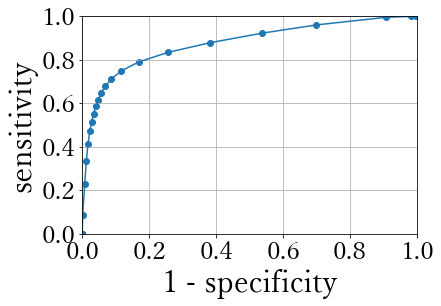

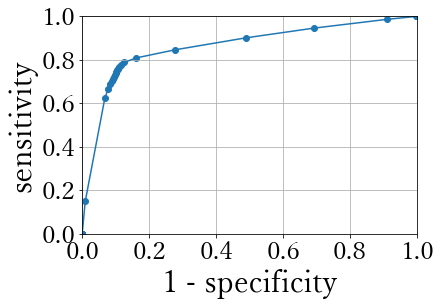

KeyboardInterrupt: 

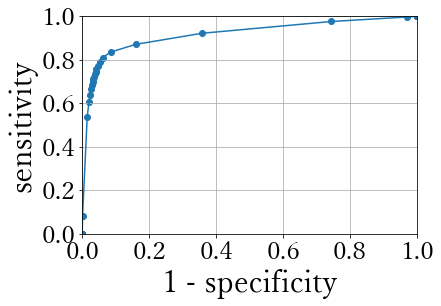

In [9]:
for experiment_name in EXPERIMENT_NAMES: # for
    print(experiment_name)
    
    results_df = pd.DataFrame({
    "case": [],
    "number": []
    })
    
    client = MlflowClient()
    N_INFERENCE = 10 if experiment_name[0] == "B" else 1
    experiment = client.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    runs = client.list_run_infos(experiment_id)
    n_runs = len(runs)
    curve_z = {
        "auc": {
            1: 0,
            2: 0,
            3: 0
        },
        "prauc": {
            1: 0,
            2: 0,
            3: 0
        }
    }
    for r, run in enumerate(runs):
        print("+"*50)
        print("{} / {}".format(r+1, n_runs))
        print("+"*50)
        run_id = run.run_id
        if run.status != "FINISHED":
            raise ValueError("No FINISHED")

        seed = int(client.get_run(run_id).data.tags["seed"])
        seed_everything(seed)

        result = {
            "case": [],
            "number": [],
        }

        for k, v in EVALUATE_METHODS.items():
            result["{}_{}".format(k, seed)] = []

        run_root = run.artifact_uri.split("file://")[1]
        i = 0 #for
        
#         Y_preds_total = [] #A
#         Y_datas_total = [] #A
        for i in range(len(FOLDS)):
            i_fold = i + 1
            dataset = EvaluateDataset(FOLDS[i]["test_data"])
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=cfg.model_info.batch_size, num_workers=8, shuffle=False)

            model_path = os.path.join(run_root, "{}_fold".format(i_fold), "model.pth")
            model = exname2model(experiment_name)
            model = model.to(cfg.device)
            
            flag = True
            try:
                model.load_state_dict(torch.load(model_path))
            except:
                if (cfg.device[:4] == "cuda") & (cfg.multi_gpu):
                    model = nn.DataParallel(model, device_ids=cfg.multi_device_ids)
                model.load_state_dict(torch.load(model_path))
                flag = False
                
            if flag:
                print("Using Single GPU")
                
            if N_INFERENCE > 1:
                if str(model.__class__) == "<class 'torch.nn.parallel.data_parallel.DataParallel'>":
                    model.module.enable_dropout()
                else:
                    model.enable_dropout()

            Y_preds, Y_datas = model_prediction_using_dataloader(model, dataloader)
            
#             Y_preds_total.append(Y_preds.cpu()) #A
#             Y_datas_total.append(Y_datas.cpu()) #A
            
            result["case"] += dataset.data["case_data"]
            result["number"] += dataset.data["numbers"]
            for k, v in EVALUATE_METHODS.items():
                if k in ["auc", "prauc"]:
                    score, z = v(Y_preds, Y_datas, experiment_name, i_fold)
                    curve_z[k][i_fold] += z / n_runs
                    result["{}_{}".format(k, seed)] += score.tolist()
                else:
                    result["{}_{}".format(k, seed)] += v(Y_preds, Y_datas).tolist()
            
#         Y_preds_total = torch.cat(Y_preds_total).to(cfg.device) #A
#         Y_datas_total = torch.cat(Y_datas_total).to(cfg.device) #A
#         auc_pytorch_with_sigmoid_each_data(Y_preds_total, Y_datas_total, experiment_name, -1) #A
#         prauc_pytorch_with_sigmoid_each_data(Y_preds_total, Y_datas_total, experiment_name, -1) #A
            
        result_df = pd.DataFrame(result)
        results_df = pd.merge(results_df, result_df, how="outer", on=["case", "number"])
    results_df.to_csv(os.path.join(ROOT_SAVE, experiment_name, "metrics_each_data.csv"), index=False)
    for k, v in EVALUATE_METHODS.items():
        if k in ["auc", "prauc"]:
            zs = []
            for i in range(len(FOLDS)):
                i_fold = i + 1
                z = curve_z[k][i_fold]
                zs.append(z)
                curve_plot(z, k, experiment_name, i_fold)
            z = sum(zs) / len(FOLDS)
            curve_plot(z, k, experiment_name, -1)

In [18]:
ename2tname = {
    "UNet_D-aug1": "ExUnet1",
    "UNet_D-aug5": "ExUnet2",
    "BUNet_D-aug1": "ExBUnet1",
    "BUNet_D-aug5": "ExBUnet3",
    
    "BUNet_UD-aug1": "ExBUnet2",
    "BUNet_UD-aug5": "ExBUnet4",
    
    "BUNet_UD2-aug1": "ExBUnet2",
    "BUNet_UD2-aug5": "ExBUnet4",
}

# ename2tname = {
#     "UNet_D-aug1": "U-Net",
#     "UNet_D-aug5": "U-Net + D",
#     "BUNet_D-aug1": "Bayesian U-Net",
#     "BUNet_D-aug5": "Bayesian U-Net + D",
    
#     "BUNet_UD-aug1": "Bayesian U-Net + L",
#     "BUNet_UD-aug5": "Bayesian U-Net + D + L",
    
#     "BUNet_UD2-aug1": "Bayesian U-Net + L",
#     "BUNet_UD2-aug5": "Bayesian U-Net + D + L",
# }

m2mname = {
    "f": "F値",
    "precision": "適合率",
    "recall": "再現率",
    "auc": "AUC",
    "prauc": "PRAUC",
    
    "ft_precision": "緩和適合率",
    "ft_recall": "緩和再現率",
    "ft_f": "緩和F値",
}

COMPARE_EXPERIMENT_NAMES = [
    "UNet_D-aug1", 
    "UNet_D-aug5",
    "BUNet_D-aug1",
    "BUNet_UD2-aug1",
    "BUNet_D-aug5",
# #     "BUNet_UD-aug1",
# #     "BUNet_UD-aug5",
    "BUNet_UD2-aug5",
                   ]

COMPARE_EXPERIMENT_NAMES = [
    "UNet_D-aug1", 
    "BUNet_D-aug1",
                   ]

# COMPARE_EXPERIMENT_NAMES = [
#     "BUNet_D-aug1",
#     "BUNet_UD2-aug1",
#                    ]

# COMPARE_EXPERIMENT_NAMES = [
#     "UNet_D-aug1", 
#     "UNet_D-aug5",
#     "BUNet_D-aug1",
#     "BUNet_UD2-aug1",
#     "BUNet_D-aug5",
#     "BUNet_UD2-aug5",
#                    ]

# COMPARE_EXPERIMENT_NAMES = [
#     "UNet_D-aug1", 
# #     "BUNet_D-aug1",
#                    ]

COMPARE_EVALUATE_METHODS = {
    "precision": precision_pytorch_with_sigmoid_each_data,
    "recall": recall_pytorch_with_sigmoid_each_data,
    "f":  f_pytorch_with_sigmoid_each_data,
    "prauc": prauc_pytorch_with_sigmoid_each_data,
    "auc": auc_pytorch_with_sigmoid_each_data,
}

# COMPARE_EVALUATE_METHODS = {
#     "ft_precision": ft_precision_pytorch_with_sigmoid_each_data,
#     "ft_recall": ft_recall_pytorch_with_sigmoid_each_data,
#     "ft_f":  ft_f_pytorch_with_sigmoid_each_data,
#     "auc": auc_pytorch_with_sigmoid_each_data,
# }

precision
recall
f
prauc
auc


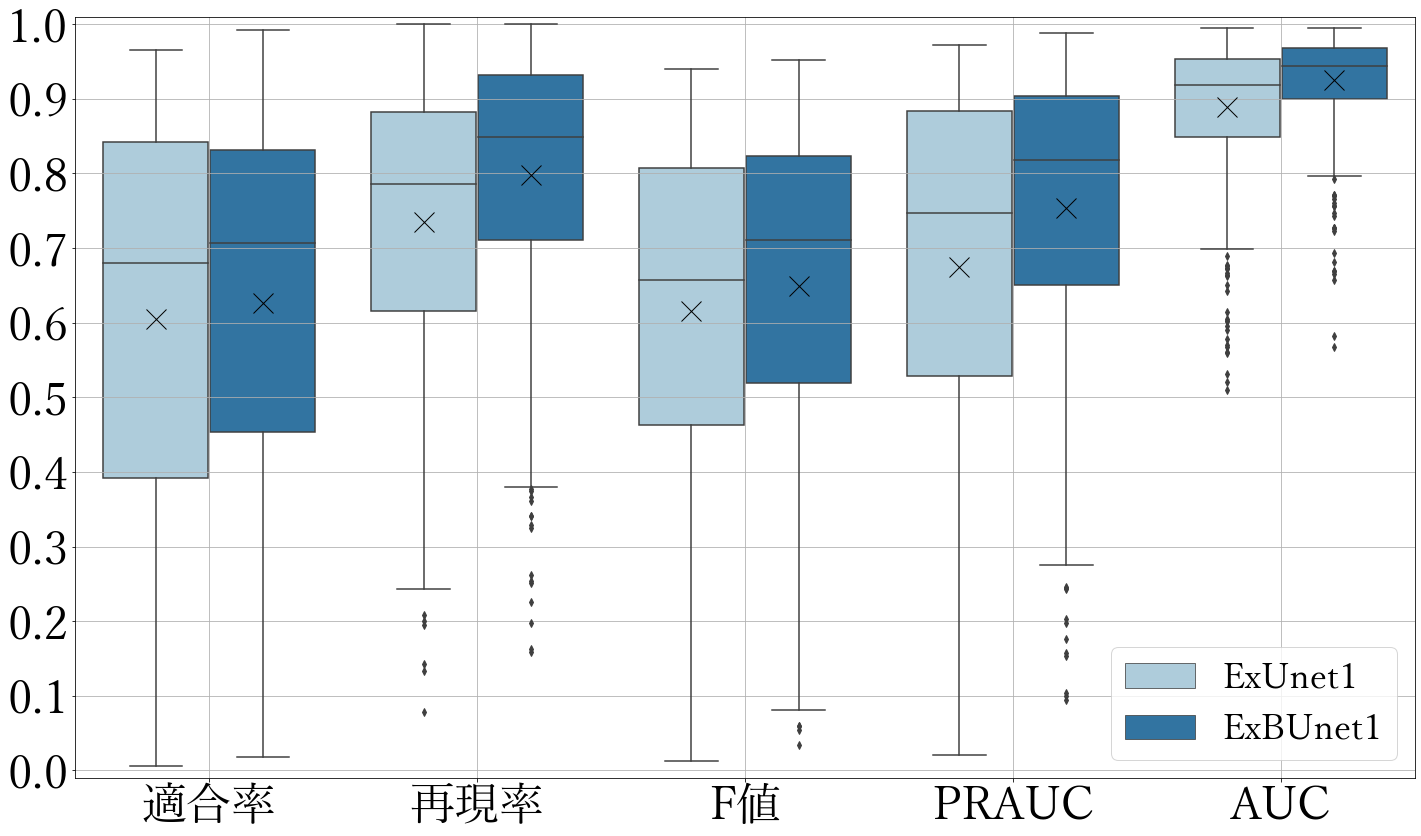

In [19]:
compare_score_dict = {
        "ExName": [],
}

k2kcolumns = {}

for k, v in COMPARE_EVALUATE_METHODS.items():
    print(k)
    compare_score_dict[k] = []

    results_df = pd.read_csv(os.path.join(ROOT_SAVE, COMPARE_EXPERIMENT_NAMES[0], "metrics_each_data.csv"))
    k_columns = list(filter(lambda x: x.find("{}_".format(k)) == 0, results_df.columns))
    k2kcolumns[k] = k_columns

for experiment_name in COMPARE_EXPERIMENT_NAMES:
        results_df = pd.read_csv(os.path.join(ROOT_SAVE, experiment_name, "metrics_each_data.csv"))
        compare_score_dict["ExName"] += [ename2tname[experiment_name]] * len(results_df)
        for k, v in COMPARE_EVALUATE_METHODS.items():
            k_columns = k2kcolumns[k]
            scores_by_data = results_df[k_columns].mean(axis=1).values
            compare_score_dict[k] += scores_by_data.tolist()
        
compare_score_df = pd.DataFrame(compare_score_dict)
compare_score_df = compare_score_df.melt(id_vars=["ExName"], var_name="metric")
compare_score_df["metric"] = compare_score_df["metric"].map(m2mname)

plt.figure(figsize=(24, 14))
plt.tick_params(labelsize=10)
plt.ylim(-0.01, 1.01, 0.1)
sns.boxplot(x="metric", y="value",hue="ExName", showmeans=True, data=compare_score_df,
            meanprops={
                "marker":"x", 
                "markeredgecolor":"black",
                "markersize":"20"
            },
#             palette=sns.color_palette("hls", 8),
            palette=sns.color_palette("Paired"),
#             palette=sns.color_palette("Paired")[2:],
)
plt.yticks(np.arange(0, 1.01, 0.10))
# plt.xticks(np.arange(0, 7))
plt.tick_params(labelsize=45)
plt.ylabel("")
plt.xlabel("")
plt.grid(True)
plt.legend(prop={"size": 35}, loc="lower right")
plt.savefig(os.path.join(ROOT_SAVE, "compare_unet.pdf"), bbox_inches='tight')
# plt.savefig(os.path.join(ROOT_SAVE, "compare_bunet.pdf"), bbox_inches='tight')
# plt.savefig(os.path.join(ROOT_SAVE, "compare_all.pdf"), bbox_inches='tight')
plt.show()

In [32]:
# statistic value
means = compare_score_df.groupby(["ExName", "metric"]).mean()
stds = compare_score_df.groupby(["ExName", "metric"]).std()
medians = compare_score_df.groupby(["ExName", "metric"]).median()

# Tex
print("mean and std")
print("-"*50)
code = ""
# code += r"実験名 & 適合率($ \rm{mean} \pm \rm{std} $) & 再現率($ \rm{mean} \pm \rm{std} $) & F値($ \rm{mean} \pm \rm{std} $) & AUC($ \rm{mean} \pm \rm{std} $) \\ \hline\hline"
# code += "\n"

code += r"実験名 "
for k, v in COMPARE_EVALUATE_METHODS.items():
    code += r"& {}".format(m2mname[k])
    code += r"($ \rm{mean} \pm \rm{std} $) "
code += r"\\ \hline \hline "
code += "\n"
    

for experiment_name in COMPARE_EXPERIMENT_NAMES:
    exname = ename2tname[experiment_name]
    code += r"{}".format(exname)
    for k, v in COMPARE_EVALUATE_METHODS.items():
        mean, std, median = means.loc[exname].loc[m2mname[k]].values[0], stds.loc[exname].loc[m2mname[k]].values[0], medians.loc[exname].loc[m2mname[k]].values[0]
        code += r" & ${:.3f} \pm {:.3f}$ ".format(mean, std)
    code += r" \\ \hline" 
    code += "\n"
    
print(code)
print()

mean and std
--------------------------------------------------
実験名 & 適合率($ \rm{mean} \pm \rm{std} $) & 再現率($ \rm{mean} \pm \rm{std} $) & F値($ \rm{mean} \pm \rm{std} $) & PRAUC($ \rm{mean} \pm \rm{std} $) & AUC($ \rm{mean} \pm \rm{std} $) \\ \hline \hline 
ExUnet1 & $0.604 \pm 0.269$  & $0.735 \pm 0.196$  & $0.616 \pm 0.229$  & $0.674 \pm 0.248$  & $0.888 \pm 0.094$  \\ \hline
ExUnet2 & $0.609 \pm 0.270$  & $0.739 \pm 0.202$  & $0.621 \pm 0.235$  & $0.680 \pm 0.256$  & $0.892 \pm 0.096$  \\ \hline
ExBUnet1 & $0.626 \pm 0.255$  & $0.797 \pm 0.178$  & $0.650 \pm 0.220$  & $0.753 \pm 0.197$  & $0.925 \pm 0.066$  \\ \hline
ExBUnet2 & $0.617 \pm 0.250$  & $0.806 \pm 0.177$  & $0.649 \pm 0.218$  & $0.753 \pm 0.199$  & $0.927 \pm 0.067$  \\ \hline
ExBUnet3 & $0.623 \pm 0.258$  & $0.808 \pm 0.172$  & $0.654 \pm 0.222$  & $0.756 \pm 0.199$  & $0.925 \pm 0.066$  \\ \hline
ExBUnet4 & $0.619 \pm 0.248$  & $0.821 \pm 0.165$  & $0.656 \pm 0.215$  & $0.763 \pm 0.188$  & $0.932 \pm 0.060$  \\ \hline

